In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import scvelo as scv
import cellrank as cr
import matplotlib.patches as mpatches

# Some custom functions
import ma_codes as codes
from ma_codes import mysize, mymap
folder = "/mnt/platte_1/Projects/230721_HLCA_Lin/"
sc.settings.figdir = folder + "Plots/Lin/"
sc.set_figure_params(vector_friendly=True, dpi_save=150)

#folder = "/media/agando/206c956b-9fe0-492c-b181-e920c87f2401/Projects/<project_folder>/"

sc.settings.verbosity = 2               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.8.1, on 2023-10-06 18:02.


In [4]:
#load
Endo2 = sc.read(folder + "modified_Endo2.h5ad")

/home/agando/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
Endo2

AnnData object with n_obs × n_vars = 28782 × 56295
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 't

In [9]:
Endo2.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A2MP1', 'A3GALT2',
       ...
       'MDM2', 'NLGN1', 'PCK2', 'PKD1', 'PPM1M', 'RAB1B', 'STC1', 'STXBP1',
       'TEC', 'WFS1'],
      dtype='object', name='feature_name', length=56295)

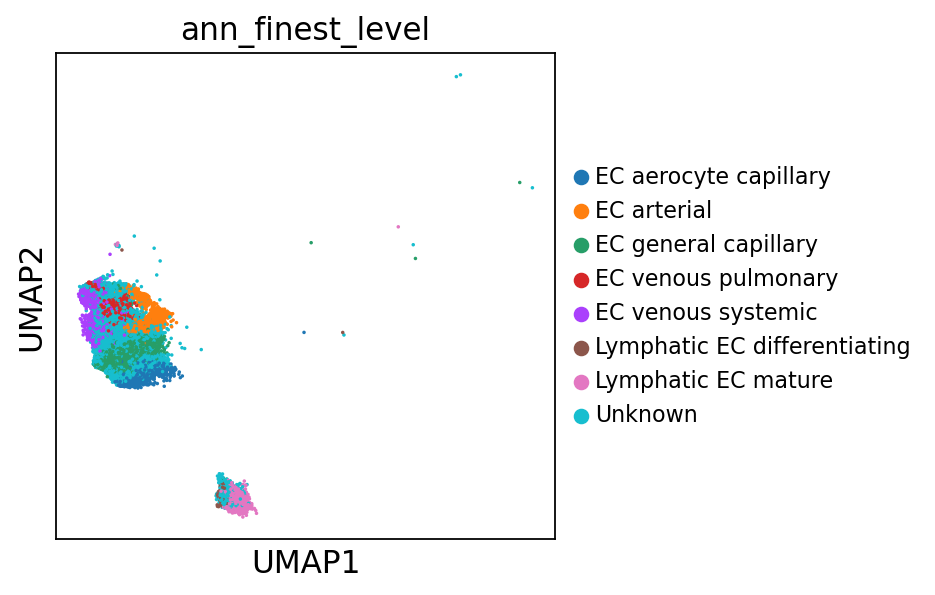

In [10]:
sc.pl.umap(Endo2, color=['ann_finest_level'], cmap=mymap, size=10, legend_fontsize=10)

In [11]:
# Set the number of PCA components you want to compute (e.g., n_comps=4)
sc.tl.pca(Endo2, n_comps=4)

computing PCA
    with n_comps=4


/home/agando/anaconda3/lib/python3.7/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  entrypoints.init_all()


    finished (0:00:04)


In [14]:
# Extract the desired PCA components (0-indexed) from the `.obsm['X_pca']` attribute
pca_components = Endo2.obsm['X_pca'][:, [0, 1]]

# Run the UMAP algorithm using the extracted PCA components
sc.pp.neighbors(Endo2, n_neighbors=10, use_rep='X_pca')  # Adjust the number of neighbors based on your dataset
sc.tl.umap(Endo2, init_pos=pca_components)

computing neighbors
    finished (0:00:12)
computing UMAP
    finished (0:00:04)


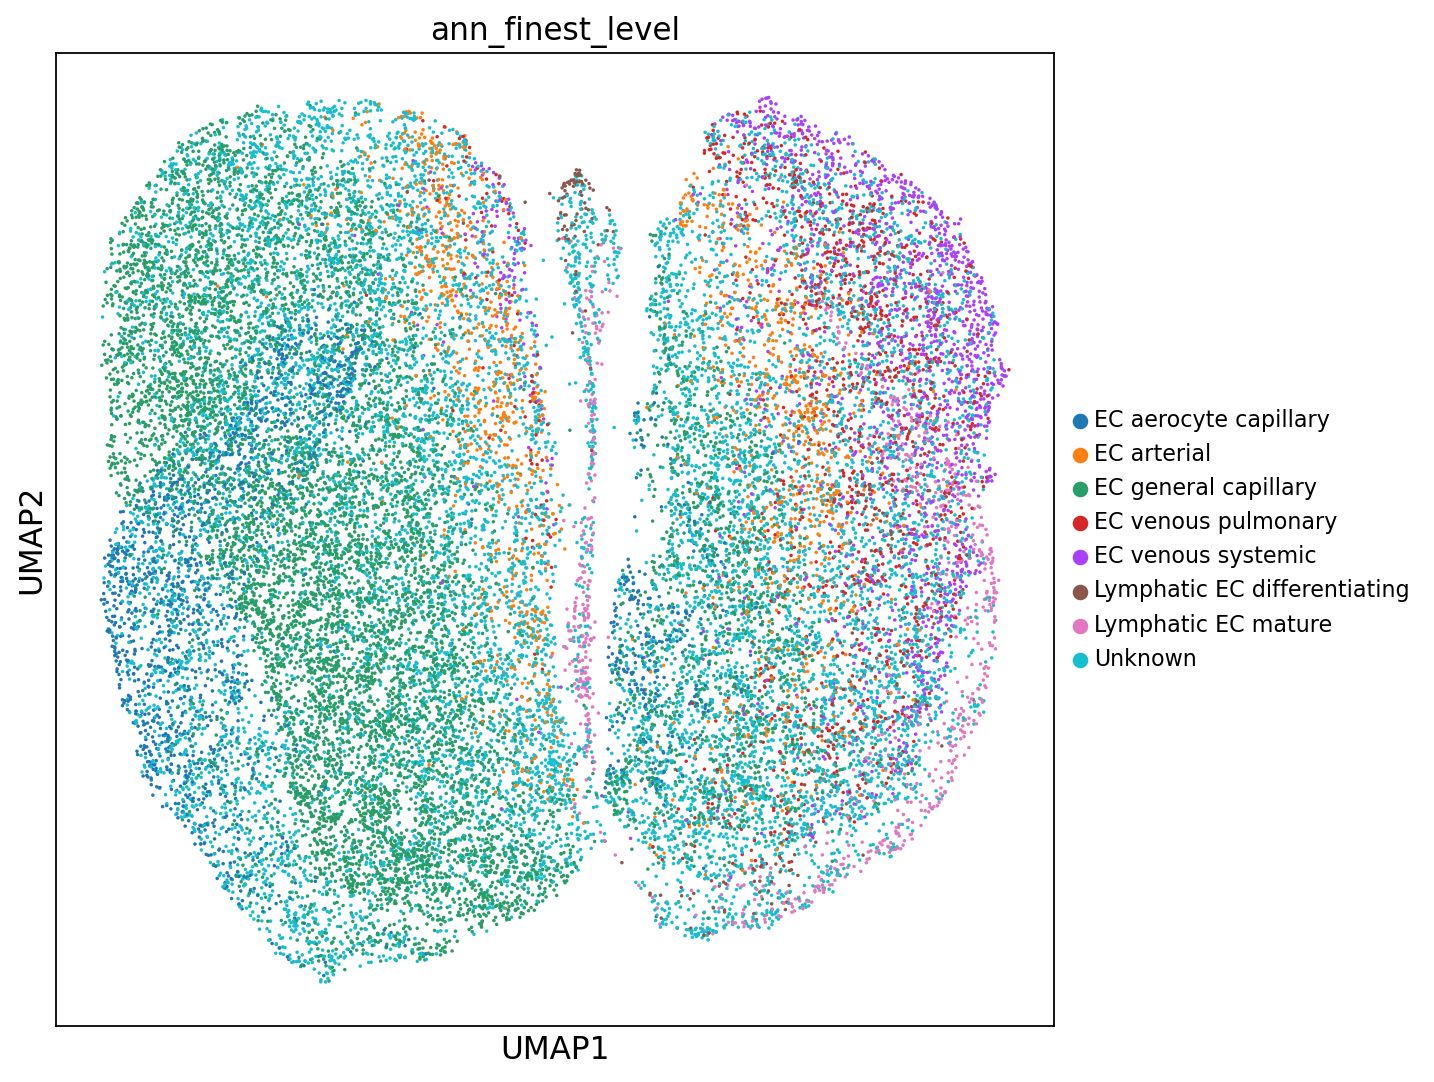

In [15]:
width = 8
height = 8

# Set the figure size before calling the sc.pl.umap function
plt.rcParams['figure.figsize'] = (width, height)

# Plot the UMAP visualization using the calculated UMAP embedding
sc.pl.umap(Endo2, color=['ann_finest_level'], cmap=mymap, size=10, legend_fontsize=10)

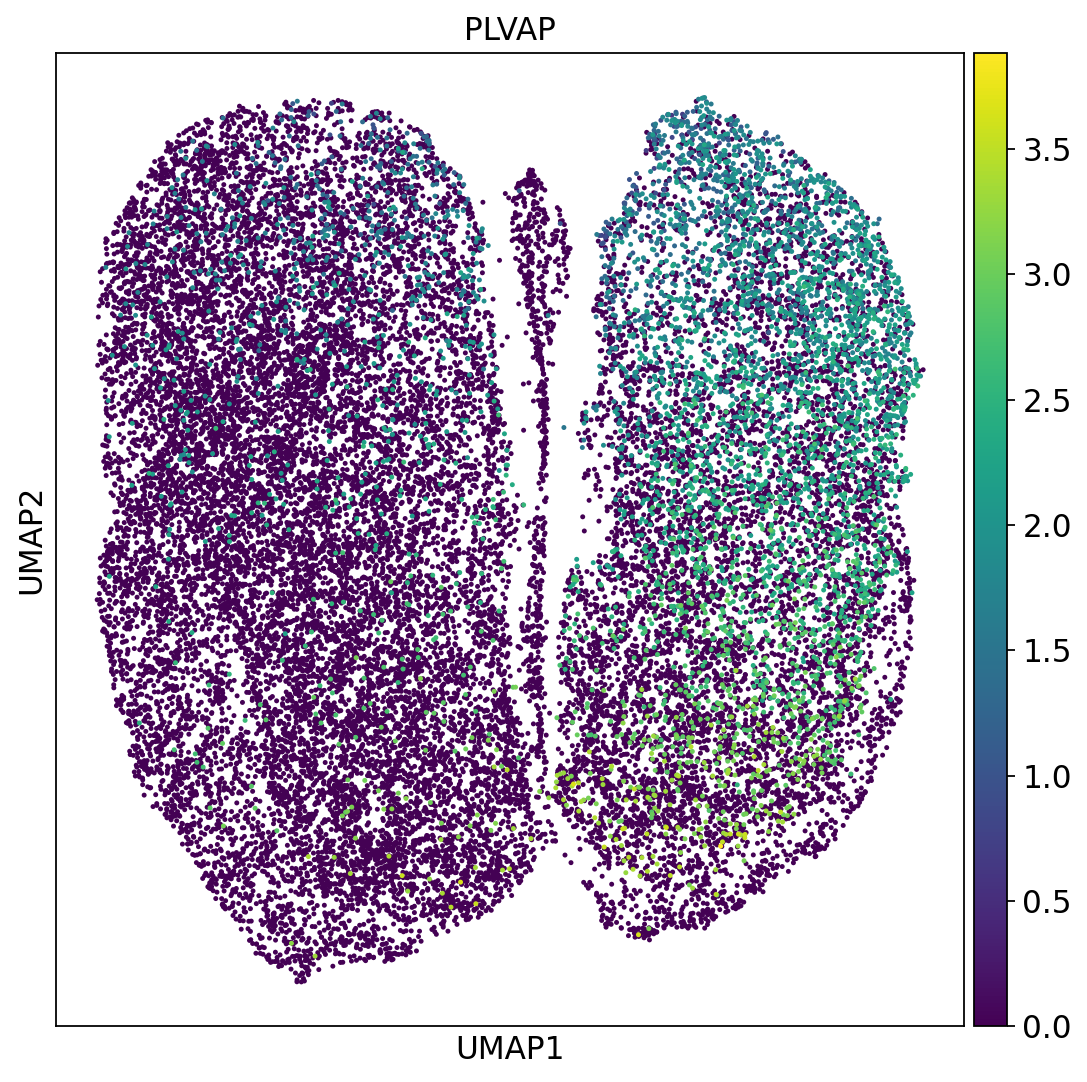

In [16]:
sc.pl.umap(Endo2, color=["PLVAP"], ncols=2, size=20, cmap='viridis', use_raw=False)

normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished (0:01:17)


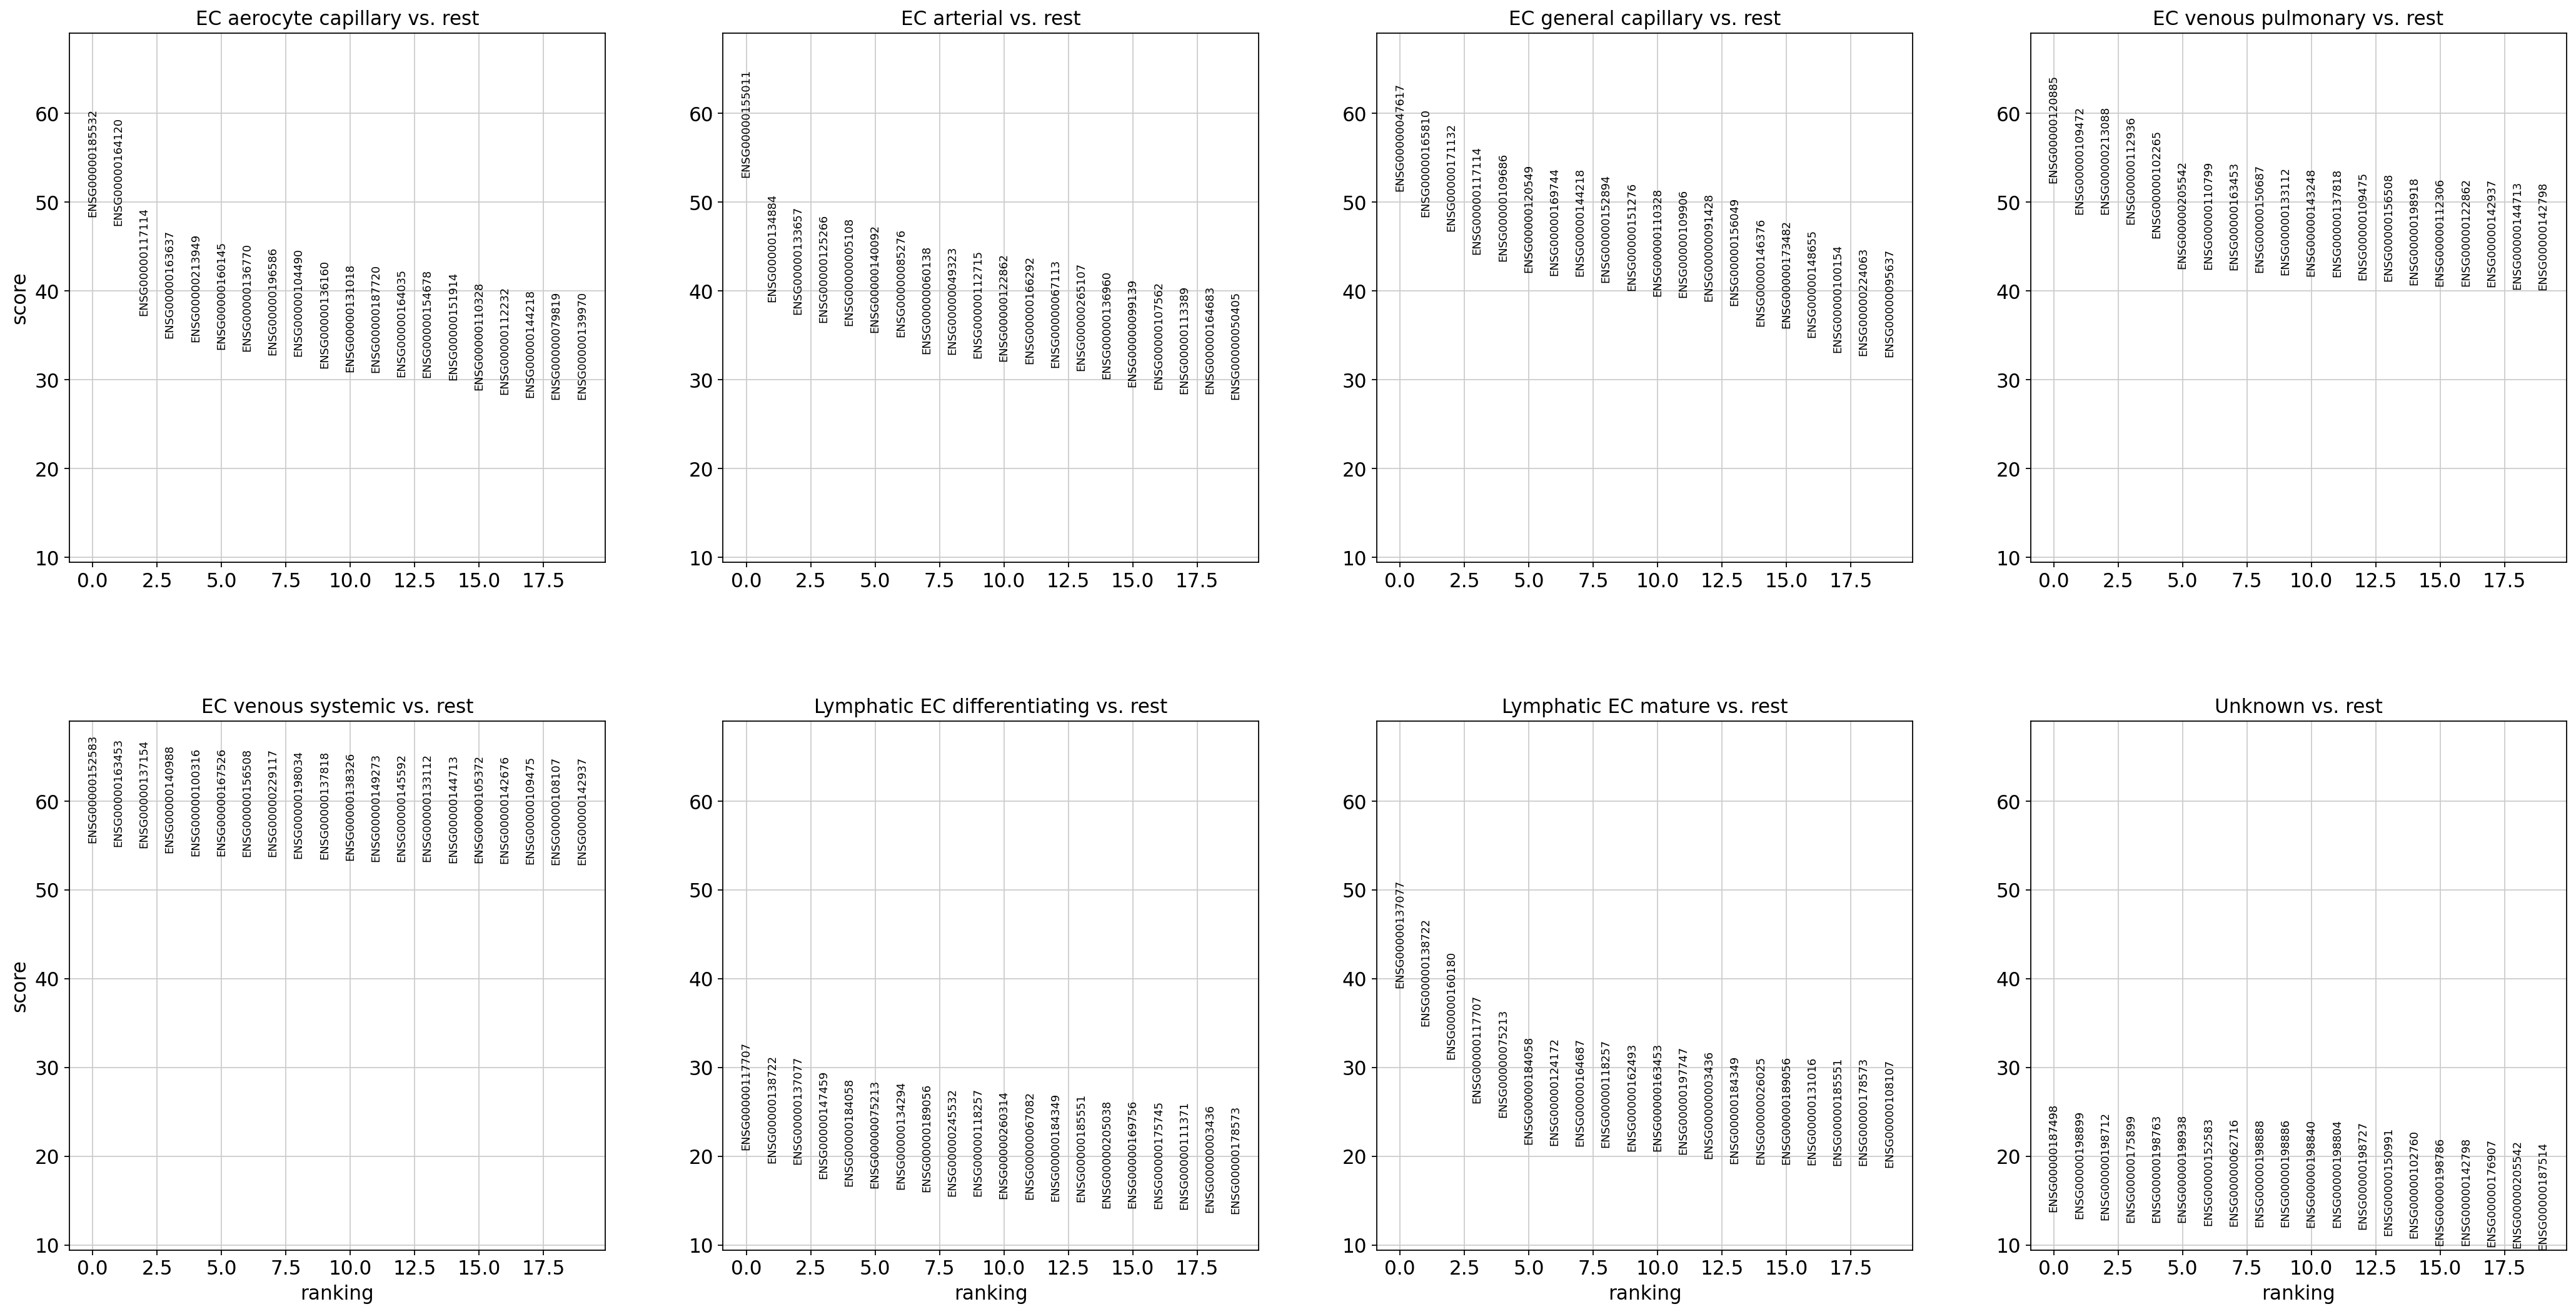

In [17]:
# Step 1: Preprocess and normalize the data
sc.pp.normalize_total(Endo2, target_sum=1e4)  # Choose the target_sum based on your data

# Step 2: Log-transform the data
sc.pp.log1p(Endo2)

# Step 3: Perform differential expression analysis using rank_genes_groups
sc.tl.rank_genes_groups(Endo2, groupby='ann_finest_level', groups='all', method='wilcoxon', n_genes=20)

# View the results
sc.pl.rank_genes_groups(Endo2)

Index(['feature_is_filtered', 'original_gene_symbols', 'feature_name',
       'feature_reference', 'feature_biotype'],
      dtype='object')


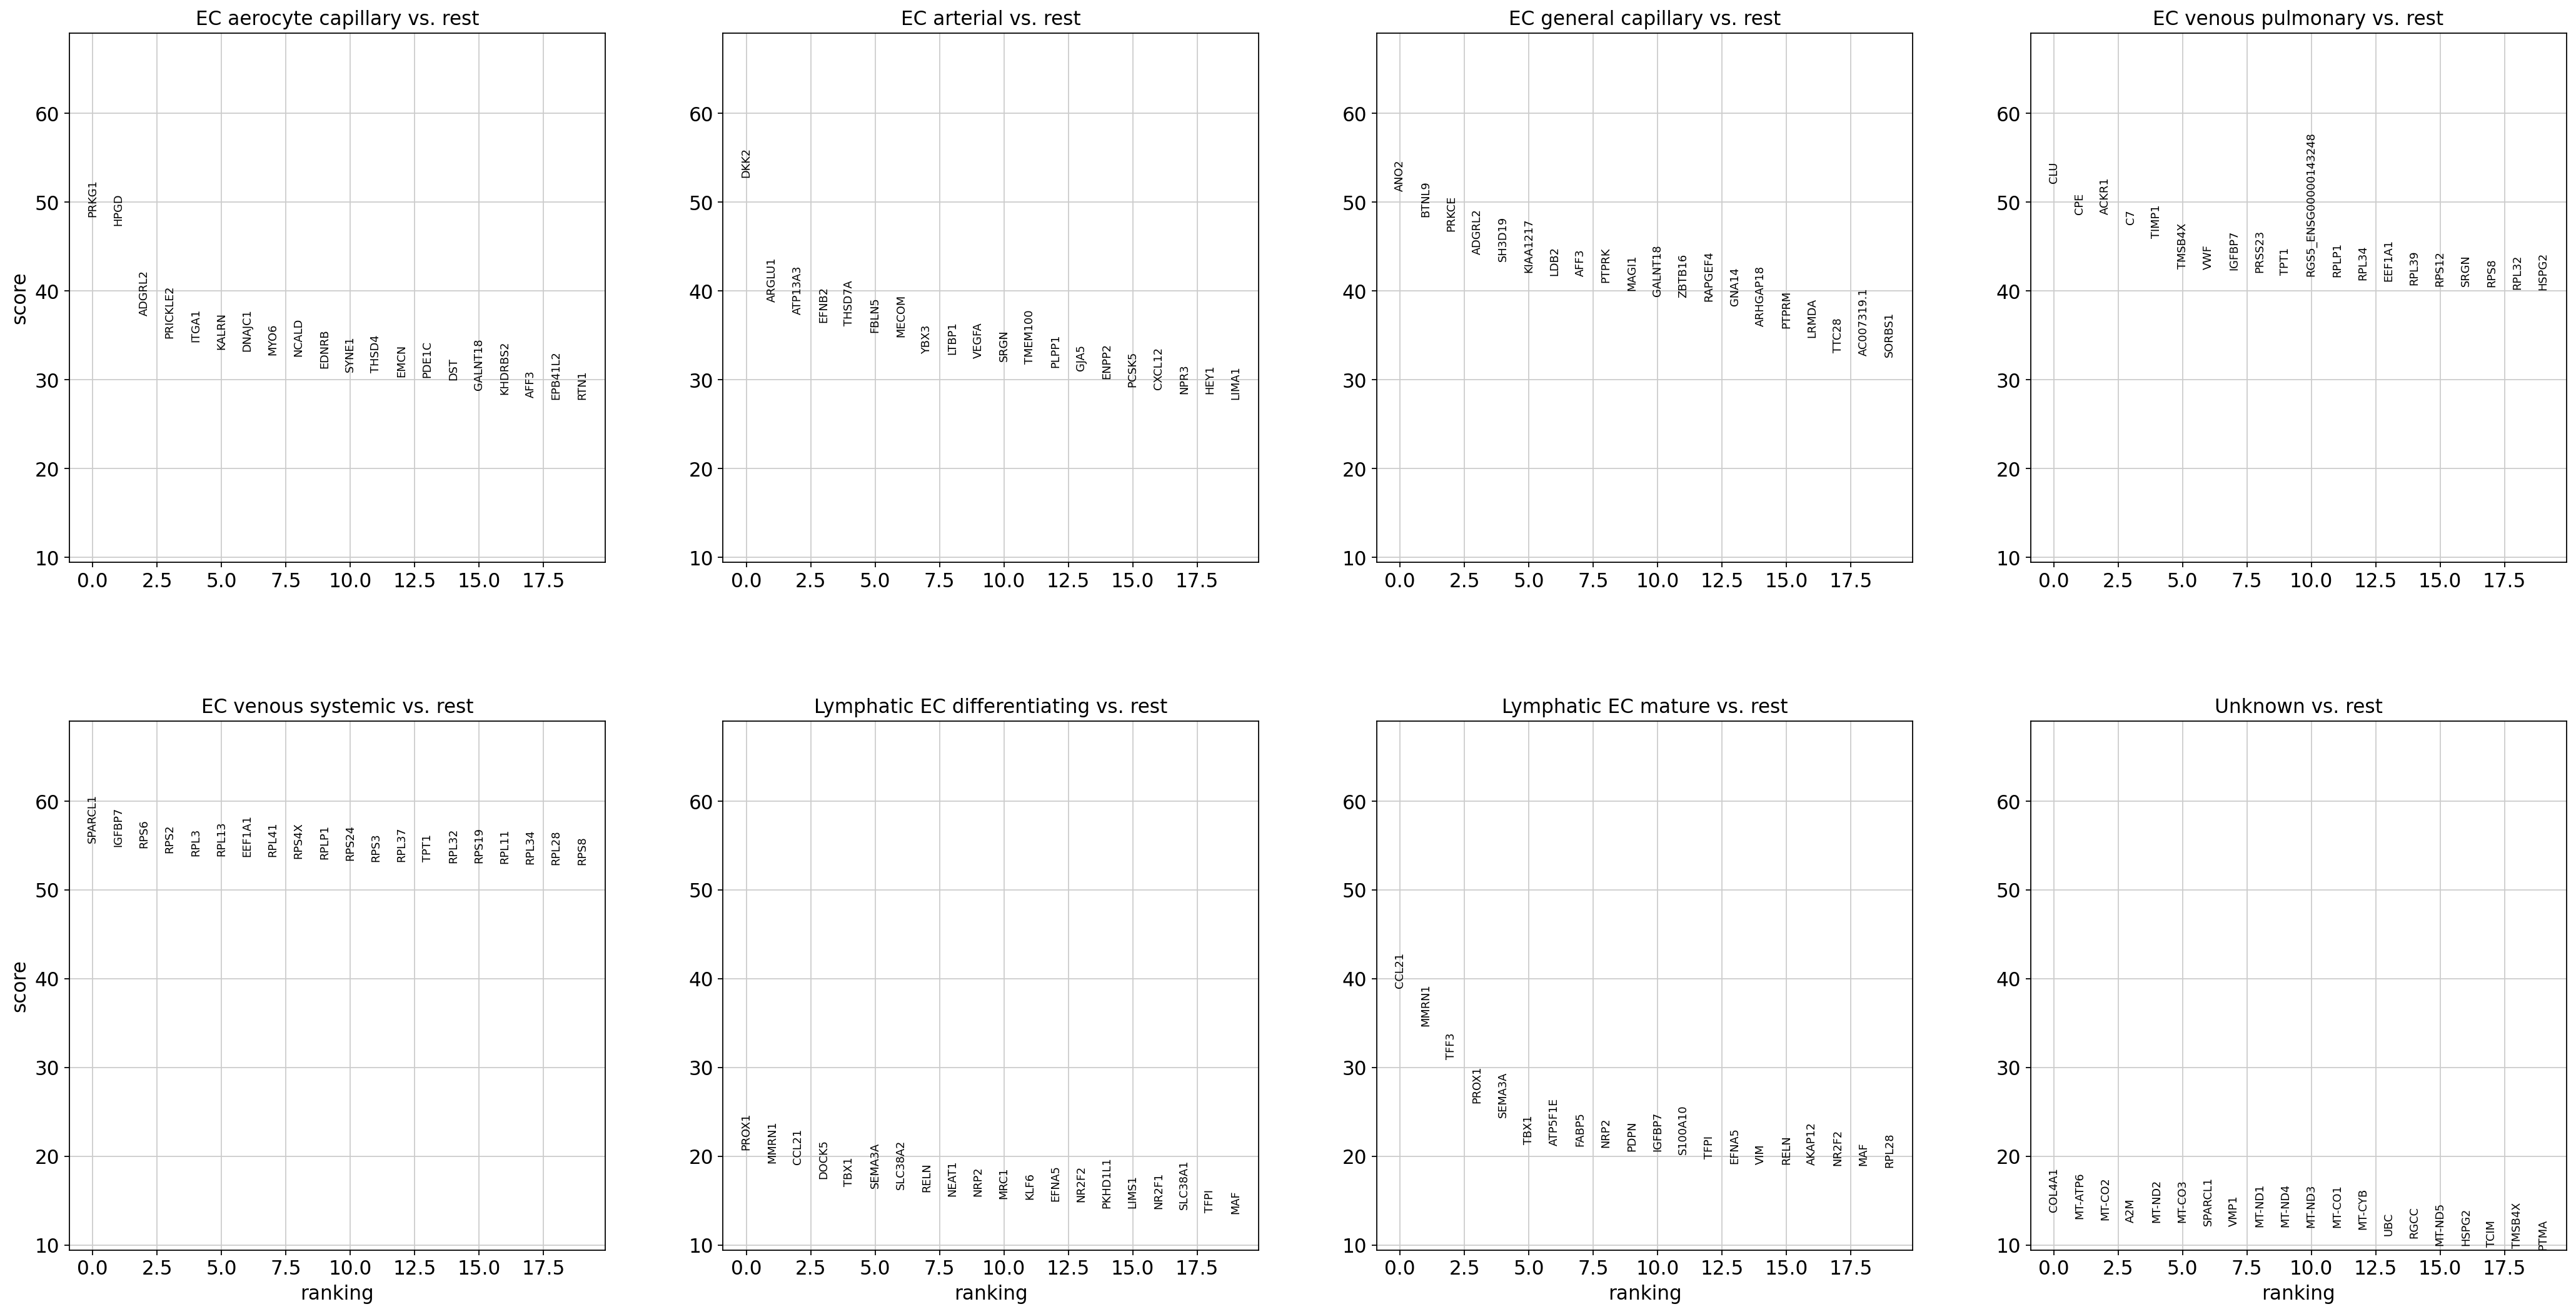

In [18]:
print(Endo2.var.columns)

Endocells.var.index = Endo2.var['feature_name']

sc.pl.rank_genes_groups(Endo2, gene_symbols="feature_name")

    using 'X_pca' with n_pcs = 4
Storing dendrogram info using `.uns['dendrogram_ann_finest_level']`


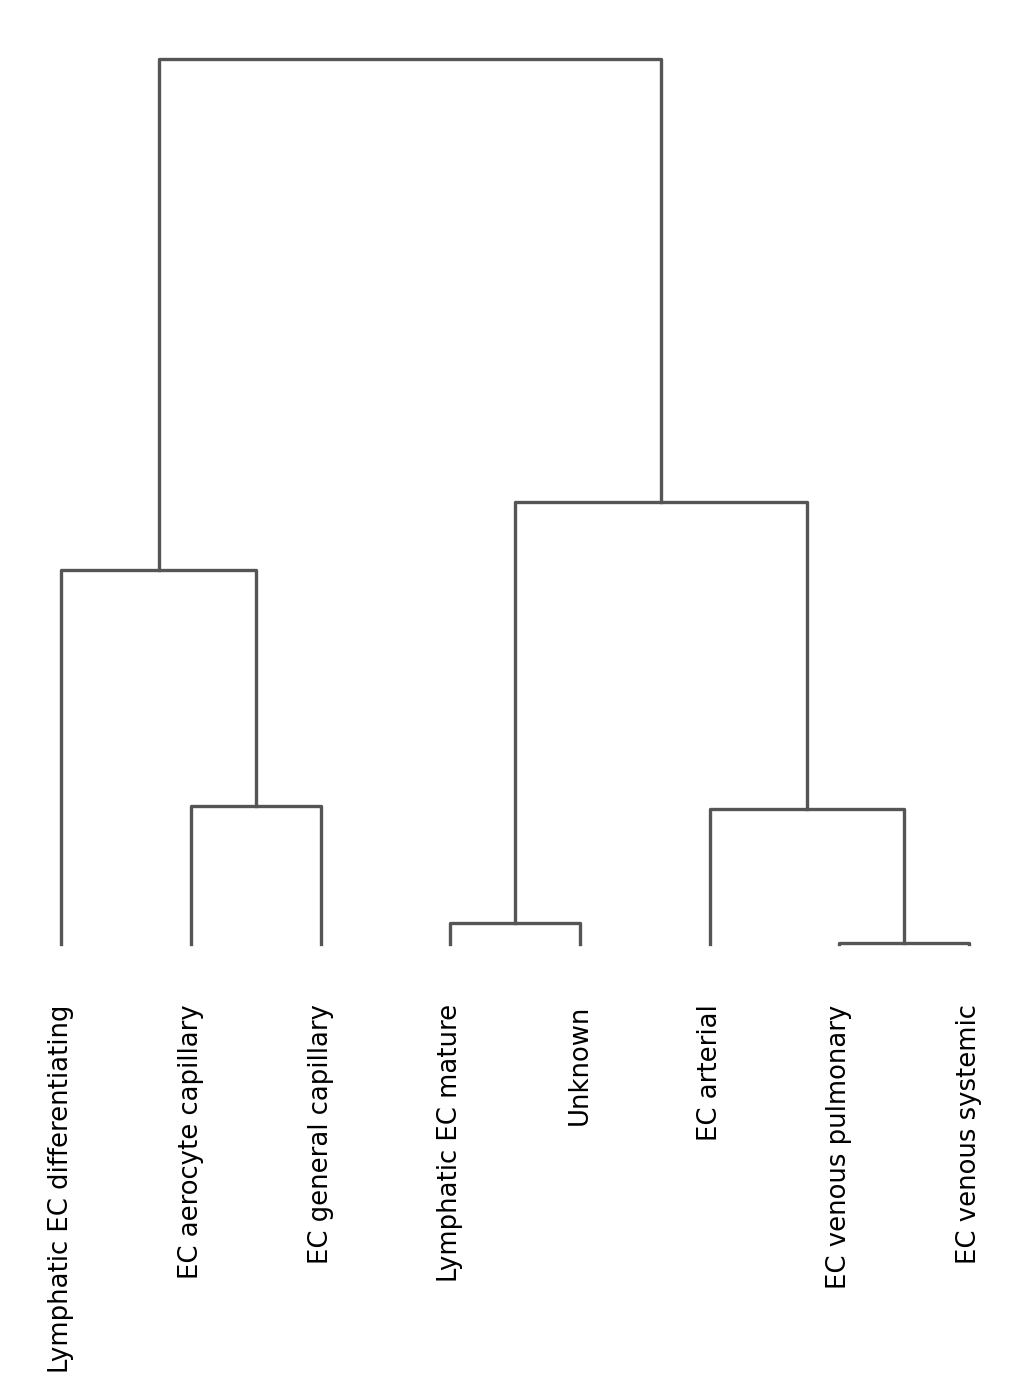

In [20]:
sc.tl.dendrogram(Endo2, 'ann_finest_level')
ax = sc.pl.dendrogram(Endo2, 'ann_finest_level')

Index(['feature_is_filtered', 'original_gene_symbols', 'feature_name',
       'feature_reference', 'feature_biotype'],
      dtype='object')


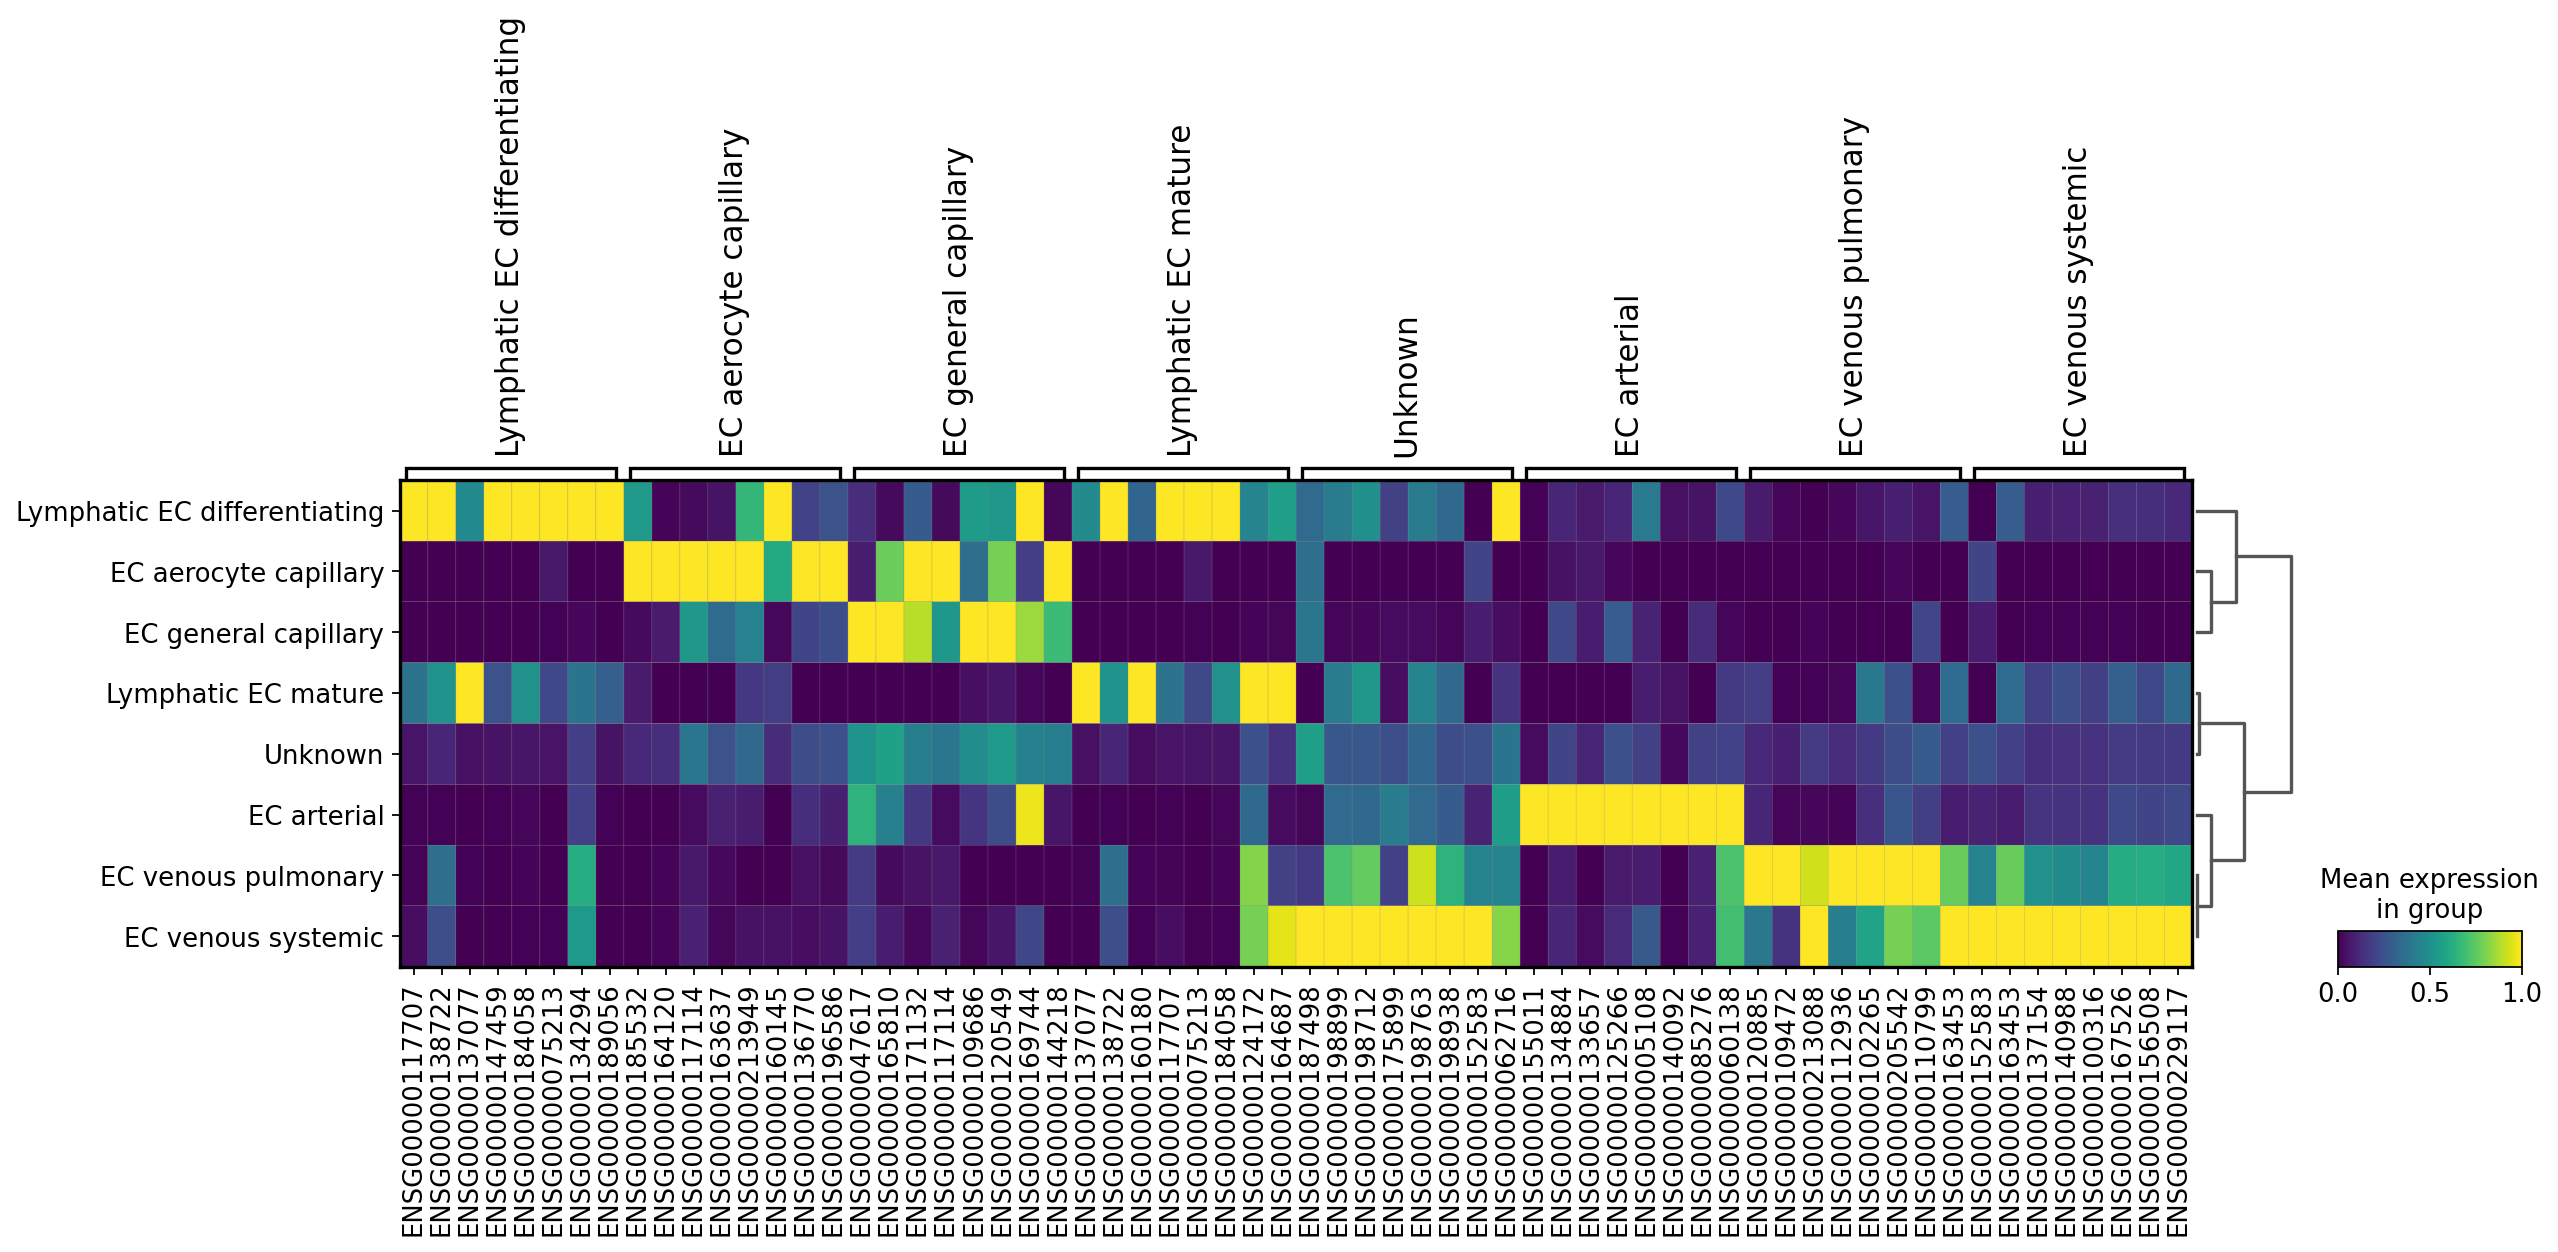

In [26]:
# Assuming you have a DataFrame with gene symbols called 'gene_symbols'
# Endo2.var.index = Endo2.var["feature_name"]

print(Endo2.var.columns)

Endocells.var.index = Endo2.var['original_gene_symbols']

# Now, when you plot the rank_genes_groups_matrixplot, it should use gene symbols
axs = sc.pl.rank_genes_groups_matrixplot(
    Endo2,
    n_genes=8,
    standard_scale='var',
    cmap='viridis', 
    figsize=(17, 4)
)

In [27]:
# Assuming you have a DataFrame with gene symbols called 'gene_symbols'
# Endo2.var.index = Endo2.var["feature_name"]

print(Endo2.var.columns)

Endocells.var.index = Endo2.var['original_gene_symbols']

# Now, when you plot the rank_genes_groups_matrixplot, it should use gene symbols
axs = sc.pl.rank_genes_groups_matrixplot(
    Endo2,
    n_genes=8,
    standard_scale='var',
    cmap='viridis', 
    gene_symbols="original_gene_symbols",
    figsize=(17, 4)
)



Index(['feature_is_filtered', 'original_gene_symbols', 'feature_name',
       'feature_reference', 'feature_biotype'],
      dtype='object')


KeyError: 'original_gene_symbols'